Cấu hình GPU của colab

In [ ]:
!nvidia-smi

Mon Nov 30 00:30:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     8W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Liên kết để truy xuất dữ liệu trong google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DeepLearning20201

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1zAYAVH93pv8035fL1Si7wl1J85cSZ94I/DeepLearning20201


In [ ]:
classNames = {0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right',
 39: 'Keep left',
 40: 'Roundabout mandatory',
 41: 'End of no passing',
 42: 'End of no passing by vehicles over 3.5 metric tons'}

import các thư viện cần thiết và check xem có đang sử dụng gpu không

In [ ]:
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import csv
import torchvision

# check xem có đang sử dụng gpu hay không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# random seed
torch.manual_seed(1)

cuda


Lấy dữ liệu gồm 3 tập train, valid và test

In [ ]:
data = "./dataset/"
train_link = data + "train.p"
valid_link = data + "valid.p"
test_link = data + "test.p"

with open(train_link, mode = "rb") as f:
  train = pickle.load(f)
with open(valid_link, mode = "rb") as f:
  valid = pickle.load(f)
with open(test_link, mode = "rb") as f:
  test = pickle.load(f)

trainX = train["features"]
trainY = train["labels"]
testX = test["features"]
testY = test["labels"]
validX = valid["features"]
validY = valid["labels"]

Hiển thị ngẫu nhiên 25 ảnh trong tập train

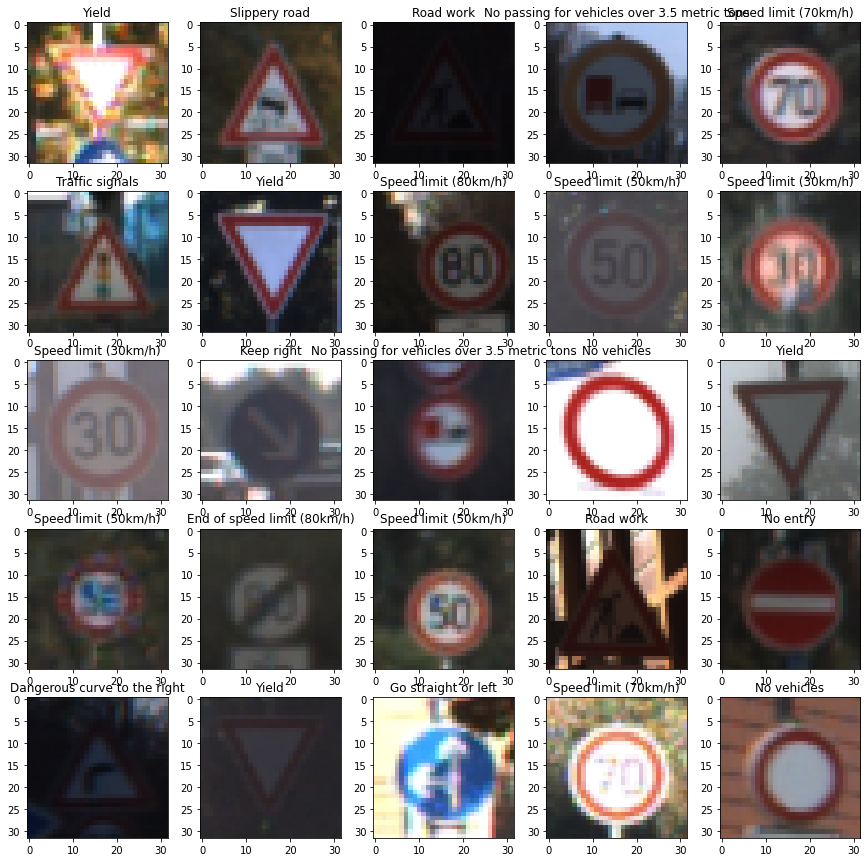

In [ ]:
fig, ax = plt.subplots(5, 5, figsize = (15, 15))
for i in range(0,25):
    sample = np.random.choice(range(len(trainX)))
    ax[i//5, i%5].imshow(trainX[sample])
    ax[i//5, i%5].set_title(classNames[trainY[sample]])    

plt.show()

Chuẩn hóa dữ liệu về khoảng [0, 1]

In [ ]:
trainX = trainX.astype("float")/255.0
validX = validX.astype("float")/255.0
testX = testX.astype("float")/255.0

Chuyển đổi dữ liệu về dạng tesnor trong torch và chỉ định dùng gpu

In [ ]:
trainX = torch.tensor(trainX).float().cuda()
trainY = torch.tensor(trainY).long().cuda()
testX = torch.tensor(testX).float().cuda()
testY = torch.tensor(testY).long().cuda()
validX = torch.tensor(validX).float().cuda()
validY = torch.tensor(validY).long().cuda()

Kích thước dữ liệu

In [ ]:
print('train size:', trainX.shape[0])
print('test size:', testX.shape[0])
print('valid size:', validX.shape[0])
print('input shape:', trainX[0].shape)

train size: 34799
test size: 12630
valid size: 4410
input shape: torch.Size([32, 32, 3])


Xây dựng mô hình gồm 4 khối convolutional và 1 khổi dense

In [ ]:
NUM_CLASSES = 43
input_size = (32,32,3)

class Model(nn.Module):
  def __init__(self, num_channels=16, num_hidden=256):
    super(Model, self).__init__()
    self.num_channels = num_channels
    self.num_hidden = num_hidden
    self.conv = nn.ModuleList()

    self.conv.append(nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=num_channels, kernel_size=(3,3), stride=1, padding=1),
        nn.BatchNorm2d(num_features=num_channels),
        nn.ReLU()
    ))
    self.conv.append(nn.Sequential(
        nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=(3,3), stride=1, padding=1),
        nn.MaxPool2d(kernel_size=(2,2), stride=2),
        nn.BatchNorm2d(num_features=num_channels),
        nn.ReLU()
    ))
    self.conv.append(nn.Sequential(
        nn.Conv2d(in_channels=num_channels, out_channels=num_channels*2, kernel_size=(3,3), stride=1, padding=1),
        nn.BatchNorm2d(num_features=num_channels*2),
        nn.ReLU()
    ))
    self.conv.append(nn.Sequential(
        nn.Conv2d(in_channels=num_channels*2, out_channels=num_channels*2, kernel_size=(3,3), stride=1, padding=1),
        nn.MaxPool2d(kernel_size=(2,2), stride=2),
        # nn.BatchNorm2d(num_features=num_channels*2),
        nn.ReLU()
    ))

    self.dense = nn.Sequential(
        nn.Linear(in_features=num_channels*2*8*8, out_features=num_hidden),
        #nn.Dropout(p=0.5),
        nn.BatchNorm1d(num_features=num_hidden),
        nn.ReLU(),
        nn.Linear(in_features=num_hidden, out_features=NUM_CLASSES),
        nn.Softmax(dim=1)
    )

  def forward(self, inp):
    output = inp.permute(0, 3, 1, 2).float()
    # Ảnh đi qua các tầng convolutional
    for layer in self.conv:
      output = layer(output)
    
    # Trải đều các ảnh ra thành vector
    output = torch.flatten(output, start_dim=1)
    # Qua tầng dense
    output = self.dense(output)
    # Trả về xác suất ảnh thuộc về từng nhãn lớp
    return output


Hàm thực hiện việc huấn luyện (train) và đánh giá (eval) mô hình

Hàm train huấn luyện mô hình qua 100 epoch và lưu lại mô hình có lỗi tấp nhất trên tập tối ưu

Hàm eval đánh giá mô hình theo độ chính xác (accuracy)

In [ ]:
import time

# Huấn luyện

def train(model, path, num_epochs=100, lr=0.01, batch_size=128, eval_every=1):

  with open('%s.csv' % path, mode='w', encoding='utf-8', newline='') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['loss', 'train acc', 'valid acc'])
    
  train_dataset = TensorDataset(trainX, trainY)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

  valid_dataset = TensorDataset(validX, validY)
  valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False)

  # Phương pháp tối ưu SGD với momentum = 0.9
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  # Hàm lỗi là Cross Entropy
  criterion = nn.CrossEntropyLoss()
  best_loss = 99999
  # Learing rate giảm sau khi đợi 5 epoch không thấy valid loss giảm
  lr_patience = 5
  # Mỗi lần giảm learing rate đi 1/3
  lr_factor = 3
  for epoch in range(1, num_epochs+1):
    model.train()
    clock0 = time.time()
    for X, Y in train_dataloader:
      # cho gradient bằng 0
      optimizer.zero_grad()
      # Forward
      output = model(X.cuda())
      # Tính lỗi
      loss = criterion(output, Y.cuda())
      # Back prop
      loss.backward()
      # Gradient descent step
      optimizer.step()

    clock1 = time.time()

    if epoch % eval_every == 0:
      train_acc, train_loss = eval(model, train_dataloader)
      valid_acc, valid_loss = eval(model, valid_dataloader)
      clock2 = time.time()
      print('| Epoch {:3d}, time={:5.1f}ms/{:5.1f}ms | Train: loss={:.3f}, acc={:5.2f}% |'.format(
          epoch, 1000 * (clock1 - clock0), 1000 * (clock2 - clock1), train_loss, 100 * train_acc), end='')
            
      print(' Valid: loss={:.3f}, acc={:5.2f}% |'.format(valid_loss, 100 * valid_acc), end='')

      if best_loss > valid_loss:
        best_loss = valid_loss
        # Lưu lại mô hình tốt nhất
        torch.save(model.state_dict(),'%s.pt' % path)
        lr_patience = 5
        print(' *', end='')
      else:
        lr_patience -= 1
        if lr_patience < 0:
          # Điều chỉnh learning rate
          lr /= lr_factor
          optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
          print(' lr={:.1e}'.format(lr), end='')
          lr_patience = 5

      print()

      with open('%s.csv' % path, mode='a', encoding='utf-8', newline='') as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([train_loss.item(), train_acc.item(), valid_loss.item(), valid_acc.item()])

# Đánh giá

def eval(model, dataloader):
  model.eval()
  predict_true = 0
  total = 0
  loss = 0
  criterion = nn.CrossEntropyLoss()
  for X, Y in dataloader:
    with torch.no_grad():
      output = model(X.cuda())

    loss += criterion(output, Y.cuda())
    predicted = torch.argmax(output, dim = 1)
    predict_true += sum((predicted == Y).float())
    total += Y.shape[0]
  return predict_true/total, loss/len(dataloader)

Các siêu tham số của mô hình gồm có learning rate, batch size, số channel, sô neural tầng ẩn.

Kích thước đầu ra của các tầng và số tham số tương ứng.

In [ ]:
lr = 0.1 # learning rate
batch_size = 128 #  batch size
num_channels = 48 # số channel
num_hidden = 256 # sô neural tầng ẩn
input_size = (32,32,3) # kích thước ảnh đầu vào

path = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, batch_size, num_channels, num_hidden)

model = Model(num_channels=num_channels, num_hidden=num_hidden).to(device)
summary(model, input_size, batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 48, 32, 32]           1,344
       BatchNorm2d-2          [128, 48, 32, 32]              96
              ReLU-3          [128, 48, 32, 32]               0
            Conv2d-4          [128, 48, 32, 32]          20,784
         MaxPool2d-5          [128, 48, 16, 16]               0
       BatchNorm2d-6          [128, 48, 16, 16]              96
              ReLU-7          [128, 48, 16, 16]               0
            Conv2d-8          [128, 96, 16, 16]          41,568
       BatchNorm2d-9          [128, 96, 16, 16]             192
             ReLU-10          [128, 96, 16, 16]               0
           Conv2d-11          [128, 96, 16, 16]          83,040
        MaxPool2d-12            [128, 96, 8, 8]               0
      BatchNorm2d-13            [128, 96, 8, 8]             192
             ReLU-14            [128, 9

Khởi tạo và huấn luyện mô hình

Các dòng có dấu * thể hiện lỗi trên tập tối ưu giảm, learning rate được in ra sau mỗi tần cập nhật

In [ ]:
model = Model(num_channels=num_channels, num_hidden=num_hidden).to(device)

train(model, lr=lr, batch_size=batch_size, eval_every=1, num_epochs=5, path=path)

| Epoch   1, time=18024.1ms/2791.7ms | Train: loss=3.026, acc=78.40% | Valid: loss=3.076, acc=73.51% | *
| Epoch   2, time=17827.4ms/2697.5ms | Train: loss=2.885, acc=92.03% | Valid: loss=2.921, acc=89.32% | *
| Epoch   3, time=17679.6ms/2681.0ms | Train: loss=2.828, acc=97.44% | Valid: loss=2.860, acc=95.40% | *
| Epoch   4, time=17745.6ms/2733.7ms | Train: loss=2.806, acc=99.46% | Valid: loss=2.828, acc=98.23% | *
| Epoch   5, time=17818.1ms/2728.7ms | Train: loss=2.801, acc=99.99% | Valid: loss=2.819, acc=98.93% | *


Đánh giá chất lượng của mô hình trên tập thử nghiệm

In [ ]:
c0=time.time()
test_dataset = TensorDataset(testX, testY)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
model = Model(num_channels=num_channels, num_hidden=num_hidden).to(device)
# Lấy mô hình tốt nhất đã lưu và thực hiện đánh giá
model.load_state_dict(torch.load('%s.pt' % path))

test_acc, test_loss = eval(model, test_dataloader)
c1=time.time()
print('test acc: {:5.2f}%'.format(test_acc.item()*100))
print('test loss:', test_loss.item())
print('thời gian đánh giá:', c1-c0,'s')

test acc: 97.87%
test loss: 2.8347153663635254
thời gian đánh giá: 0.8773260116577148 s


In [ ]:
model.eval()
res = model(testX[0:1])
print((res.shape))

torch.Size([1, 43])


Biểu đồ thể hiện độ chính xác của tập train và valid qua các epoch

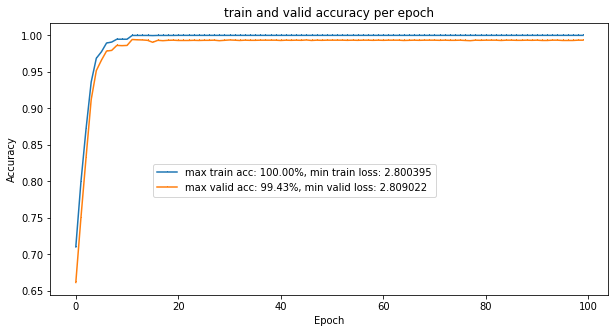

In [ ]:
with open('%s.csv' % path, mode='r', encoding='utf-8', newline='') as file:
  reader = csv.reader(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  states = [row for row in reader][1:]
  train_acc = [round(float(row[1]), 4) for row in states]
  valid_acc = [round(float(row[3]), 4) for row in states]
  train_loss = [round(float(row[0]), 6) for row in states]
  valid_loss = [round(float(row[2]), 6) for row in states]

plt.figure(figsize=(10, 5))
epochs = [i for i in range(len(valid_acc))]
plt.plot(epochs, train_acc, marker=',', label='max train acc: {:5.2f}%, min train loss: {}'.format(max(train_acc)*100, min(train_loss)))
plt.plot(epochs, valid_acc, marker=',', label='max valid acc: {:5.2f}%, min valid loss: {}'.format(max(valid_acc)*100, min(valid_loss)))

plt.legend(bbox_to_anchor=(0.7, 0.5), loc='best')
plt.title('train and valid accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Độ chính xác khi nhận dạng từng loại biển báo


Text(0.0, 1.0, 'Độ chính xác khi nhận diện từng loại biển báo')

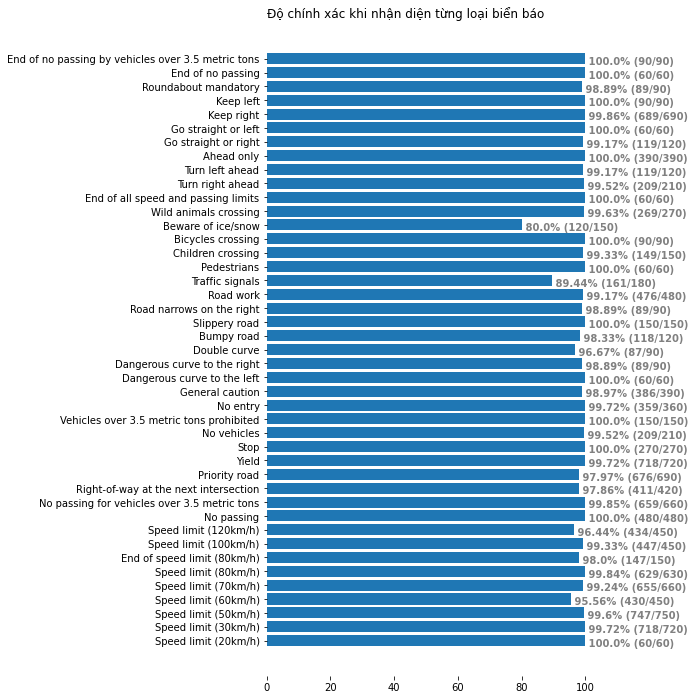

In [ ]:
model = Model(num_channels=num_channels, num_hidden=num_hidden).to(device)
model.load_state_dict(torch.load('%s.pt' % path))
test_dataset = TensorDataset(testX, testY)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
model.eval()
predict_true = [0 for i in range(NUM_CLASSES)]
total = [0 for i in range(NUM_CLASSES)]
for X, Y in test_dataloader:
  with torch.no_grad():
    output = model(X.cuda())

  predicted = torch.argmax(output, dim = 1)
  for p, s in zip(predicted, Y):
    p, s = p.item(), s.item()
    if p == s:
      predict_true[s] += 1
    total[s] += 1

accs = [predict_true[i]/total[i]*100 for i in range(NUM_CLASSES)]

x = list(classNames.values())
fig, ax = plt.subplots(figsize =(6, 12)) 
ax.barh(x, accs) 
for _, i in enumerate(ax.patches): 
  plt.text(i.get_width(), i.get_y(),  
             ' {}% ({}/{})'.format(str(round((i.get_width()), 2)), predict_true[_], total[_]), 
             fontsize = 10, fontweight ='bold', 
             color ='grey')    
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

ax.set_title('Độ chính xác khi nhận diện từng loại biển báo', 
             loc ='left', ) 

Biểu đồ so sánh các kích thước mạng

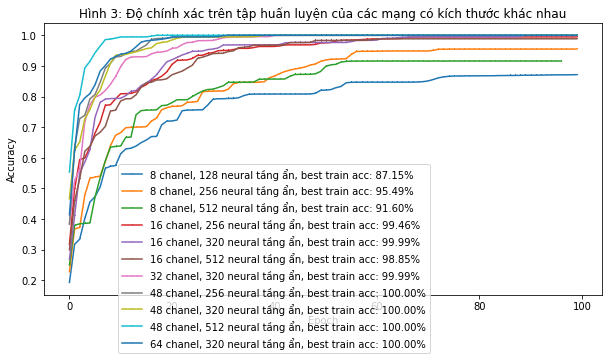

In [ ]:
sbatch=128
lr=0.01
nchanels=[8, 16, 32, 48, 64]
nhidden=[128, 256, 320, 512]

plt.figure(figsize=(10, 5))

for nc in nchanels:
  for nh in nhidden:
    try:
      path = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nc, nh)
      with open('%s.csv'%path, 'r') as f:
        reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        states = [row for row in reader][1:]
        train_acc = [round(float(row[1]), 4) for row in states]
        epochs = [i for i in range(len(train_acc))]
        plt.plot(epochs, train_acc, marker=',', label='{} chanel, {} neural tầng ẩn, best train acc: {:5.2f}%'.format(nc, nh, max(train_acc)*100))
    except:
      continue

plt.legend(bbox_to_anchor=(0.7, 0.5), loc='best')
plt.title('Hình 3: Độ chính xác trên tập huấn luyện của các mạng có kích thước khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

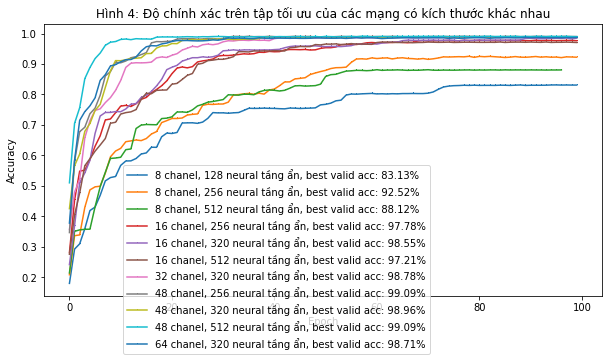

In [ ]:
sbatch=128
lr=0.01
nchanels=[8, 16, 32, 48, 64]
nhidden=[128, 256, 320, 512]

plt.figure(figsize=(10, 5))

for nc in nchanels:
  for nh in nhidden:
    try:
      path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nc, nh)
      with open('%s.csv'%path1, 'r') as f:
        reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        states = [row for row in reader][1:]
        valid_acc = []
        for row in states:
          try:
            valid_acc.append(round(float(row[3]), 4))
          except:
            valid_acc.append(round(float(row[2]), 4))
        
        epochs = [i for i in range(len(valid_acc))]
        plt.plot(epochs, valid_acc, marker=',', label='{} chanel, {} neural tầng ẩn, best valid acc: {:5.2f}%'.format(nc, nh, max(valid_acc)*100))
    except:
      continue

plt.legend(bbox_to_anchor=(0.7, 0.5), loc='best')
plt.title('Hình 4: Độ chính xác trên tập tối ưu của các mạng có kích thước khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Biểu đồ so sánh tốc độ học

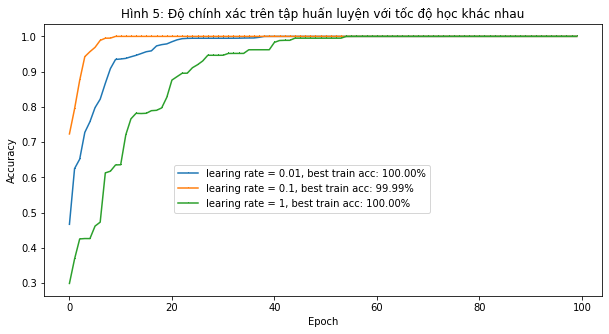

In [ ]:
sbatch=128
lrs=[0.01, 0.1, 1]
nchanels=48
nhidden=320

plt.figure(figsize=(10, 5))

for lr in lrs:
  try:
    path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nchanels, nhidden)
    with open('%s.csv'%path1, 'r') as f:
      reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      states = [row for row in reader][1:]
      train_acc = []
      for row in states:
        train_acc.append(round(float(row[1]), 4))
       
      epochs = [i for i in range(len(train_acc))]
      plt.plot(epochs, train_acc, marker=',', label='learing rate = {}, best train acc: {:5.2f}%'.format(lr, max(train_acc)*100))
  except:
    continue

plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Hình 5: Độ chính xác trên tập huấn luyện với tốc độ học khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

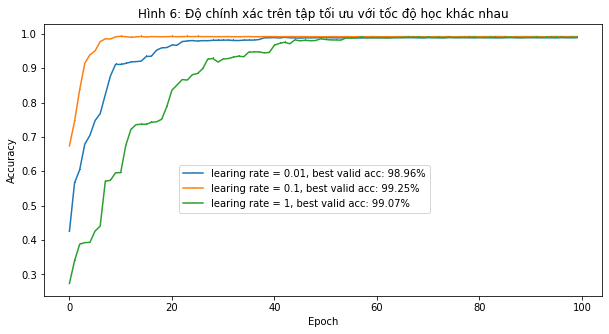

In [ ]:
sbatch=128
lrs=[0.01, 0.1, 1]
nchanels=48
nhidden=320

plt.figure(figsize=(10, 5))

for lr in lrs:
  try:
    path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nchanels, nhidden)
    with open('%s.csv'%path1, 'r') as f:
      reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      states = [row for row in reader][1:]
      valid_acc = []
      for row in states:
        try:
          valid_acc.append(round(float(row[3]), 4))
        except:
          valid_acc.append(round(float(row[2]), 4))
        
      epochs = [i for i in range(len(valid_acc))]
      plt.plot(epochs, valid_acc, marker=',', label='learing rate = {}, best valid acc: {:5.2f}%'.format(lr, max(valid_acc)*100))
  except:
    continue

plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Hình 6: Độ chính xác trên tập tối ưu với tốc độ học khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Biểu đồ so sánh batch size

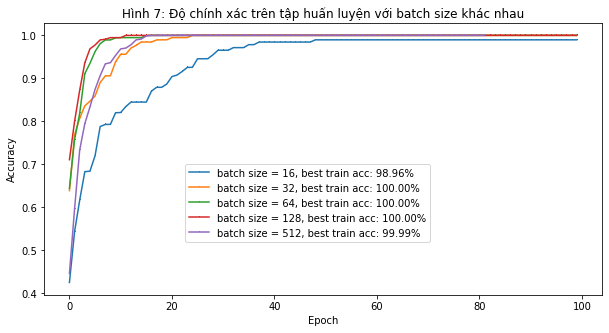

In [ ]:
sbatchs=[16, 32, 64, 128, 512]
lr=0.1
nchanels=48
nhidden=256

plt.figure(figsize=(10, 5))

for sbatch in sbatchs:
  try:
    path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nchanels, nhidden)
    with open('%s.csv'%path1, 'r') as f:
      reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      states = [row for row in reader][1:]
      train_loss = []
      for row in states:
        train_loss.append(round(float(row[1]), 6))
        
      epochs = [i for i in range(len(train_loss))]
      plt.plot(epochs, train_loss, marker=',', label='batch size = {}, best train acc: {:5.2f}%'.format(sbatch, max(train_loss)*100))
  except:
    continue

plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Hình 7: Độ chính xác trên tập huấn luyện với batch size khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

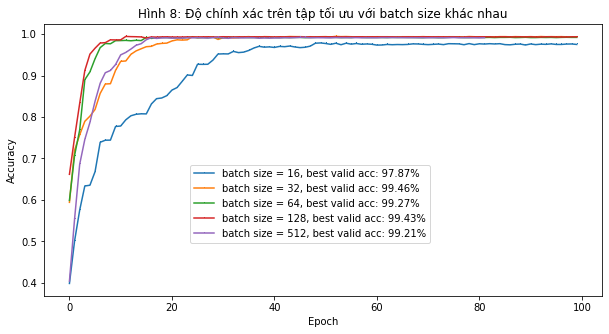

In [ ]:
sbatchs=[16, 32, 64, 128, 512]
lr=0.1
nchanels=48
nhidden=256

plt.figure(figsize=(10, 5))

for sbatch in sbatchs:
  try:
    path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nchanels, nhidden)
    with open('%s.csv'%path1, 'r') as f:
      reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      states = [row for row in reader][1:]
      valid_loss = []
      for row in states:
        valid_loss.append(round(float(row[3]), 6))
      
      epochs = [i for i in range(len(valid_loss))]
      plt.plot(epochs, valid_loss, marker=',', label='batch size = {}, best valid acc: {:5.2f}%'.format(sbatch, max(valid_loss)*100))
  except:
    continue

plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Hình 8: Độ chính xác trên tập tối ưu với batch size khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Visualize output của các tầng convolutional

In [ ]:
inp = trainX[np.random.choice(range(len(trainX)))]
out = model(inp.unsqueeze(0))
print(out)

ValueError: ignored

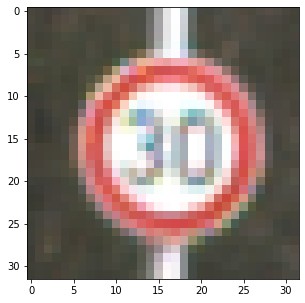

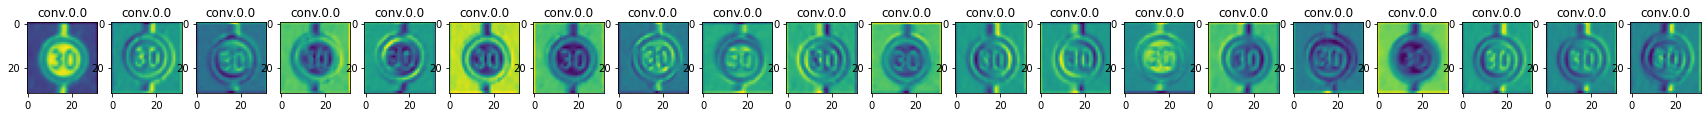

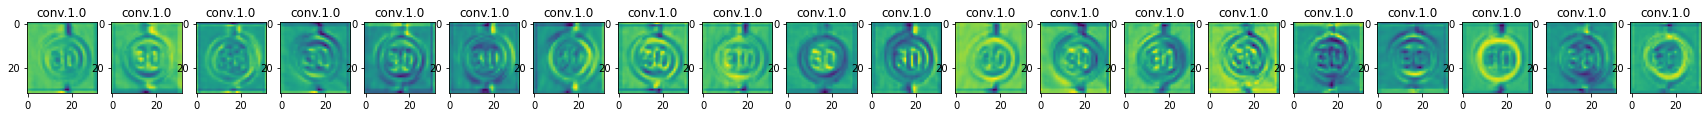

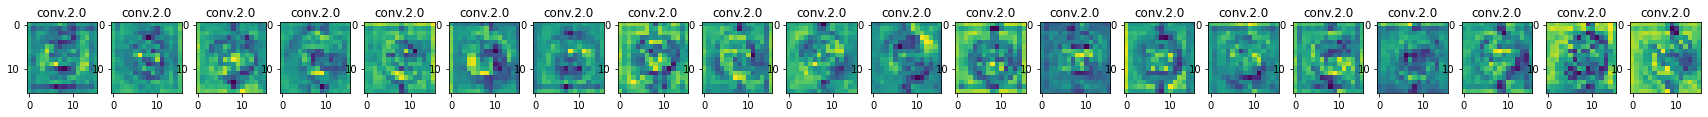

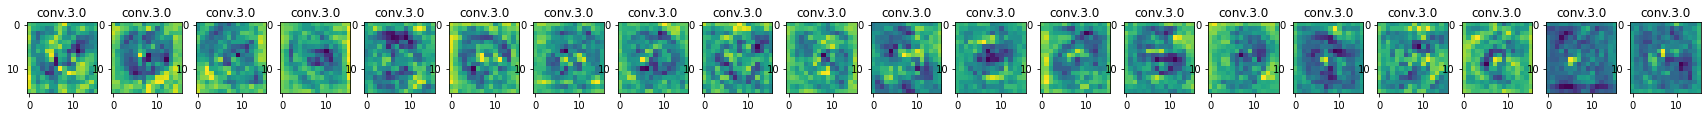

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))

inp = trainX[np.random.choice(range(len(trainX)))]

ax.imshow(inp.cpu())

in_tensor = inp.unsqueeze(0).permute(0, 3, 1, 2)
for name, module in model.named_modules():
  if isinstance(module, nn.Sequential) or isinstance(module, nn.ModuleList) or isinstance(module, Model):
    continue
  if isinstance(module, nn.Linear):
    break
  out = module(in_tensor)
  in_tensor = out
  if isinstance(module, nn.Conv2d):
    fig, ax = plt.subplots(1, 20, figsize = (30, 3))
    for i in range(20):
      p = out[0][i].cpu().detach()
      ax[i].imshow(p)
      ax[i].set_title(name)
